In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer

In [2]:
import os
from langdetect import detect
from googletrans import Translator
import emoji

In [3]:
# Function to assess the model prediction performance

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

## Loading preprocessed datasets 

In [4]:
reviews_df = pd.read_csv('output/train_reviews_with_sentiment.csv')

reviews_df['comments'] = reviews_df['comments_no_emoji'].astype('string')
reviews_df = reviews_df.dropna()

grouped = reviews_df.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()
final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count'] # rename the columns to the desired names


# Extracting and merging only English revies for now
reviews_df_eng = reviews_df[(reviews_df['language']=='en')]

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged'] # Rename the columns of the DataFrame

# Dataset constructed from Reviews
merged_reviews = pd.merge(final_grouped, grouped_eng, on='index', how='left')

# Group by 'index' and calculate median values for sentiments
grouped_sentiment = reviews_df.groupby('index')[
    ['sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']].median().reset_index()

# Creating the final features for reviews by merging with Sentiment medians
merged_reviews = pd.merge(merged_reviews, grouped_sentiment, on='index', how='left')

merged_reviews.head()

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,7,50,30.0,this is a very cozy and comfortable house to s...,0.280481,0.44905,0.992033
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...,0.292708,0.20230,-0.597586
2,8,8,168,145.0,Shani was very helpful throughout our process!...,0.422480,0.94500,0.999798
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...,0.298313,0.69305,0.973889
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment...",0.405238,0.91990,0.999775


In [5]:
#df_train_raw = pd.read_excel('Project Corpora/train.xlsx')
df = pd.read_csv('output/train_with_translation.csv') # this is the result of translation of descriptions
df.head(5)

,index,description,host_about,unlisted,description_language,host_about_language,description_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"This is a shared mixed room in our hostel, wit..."
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,"My space is close to Parque Eduardo VII, Salda..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,Trafaria’s House is a cozy and familiar villa ...
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en,"Charming apartment in Chiado, Between the Farg..."
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,Beautiful apartment on the beach.<br /> 2 min....


## Splitting data into Train and Validation

In [6]:
# Split the original train dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, 
                                    stratify=df['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train_df', train_df.shape)
print('Shapes of val_df', val_df.shape)

Shapes of train_df (9996, 7)
Shapes of val_df (2500, 7)


## Processing Train_df

### Cleaning, stemming, lemmatization

In [7]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean(text_list, lemmatize, stemmer):   
    cleaned_text_list = []  
    text_list.fillna('', inplace=True)
    for text in tqdm(text_list):           
        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned_text_list.append(text)        
    return cleaned_text_list

In [8]:
train_df['cleaned_description'] =  clean(train_df['description_english'], lemmatize = True, stemmer = False)
train_df['cleaned_host_about'] =  clean(train_df['host_about'], lemmatize = True, stemmer = False)

100%|█████████████████████████████████████████| 9996/9996 [00:00<00:00, 11343.70it/s]


In [9]:
# Merging reviews to train_df
train_df = pd.merge(train_df, merged_reviews, on='index', how='left')
train_df.head()

,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,cleaned_host_about,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",exclusive villa located quiet pinewood area co...,couple big family love travel nice welcome gue...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.97050,0.999820
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",luna house b b part luna house hub located clo...,luna house b b part luna house hub located clo...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,newly refurbished apartment swimming pool stun...,world citizen looking forward meet new people ...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.93830,0.999775
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,nice studio two people one bathroom compact ki...,hello antonio want welcome lisbon,13.0,226.0,146.0,"The studio is very charming, comfortable, has ...",0.320539,0.79285,0.999446
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",whether shorter longer stay want offer solutio...,name alexandre live lisbon love travel world c...,16.0,523.0,356.0,"I'm portuguese from Lisbon , living in Italy, ...",0.366667,0.86870,0.999623


### Defining text_based training features with HashVectorizer

In [10]:
vectorizer_desc = HashingVectorizer(n_features=1000, norm = None)
vectorizer_host = HashingVectorizer(n_features=1000, norm = None)

X_hash_desc = vectorizer_desc.fit_transform(train_df["cleaned_description"])
X_hash_host = vectorizer_host.fit_transform(train_df["cleaned_host_about"])

X_hash_desc.shape, X_hash_host.shape

((9996, 1000), (9996, 1000))

### Defining other features (based on languages, comment counts, reviews' sentiment, etc.)

In [11]:
non_text_cols = ['description_language', 'host_about_language',
                'unique_languages_count', 'total_comments_count', 'eng_comment_count',
                'sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']

other_features = train_df[non_text_cols].copy()


# Replace 'en' with 1 and others with 0 in 'description_language' and 'host_about_language'
other_features['description_language'] = np.where(other_features['description_language'] == 'en', 1, 0)
other_features['host_about_language'] = np.where(other_features['host_about_language'] == 'en', 1, 0)


# Scaling selected columns with StandardScaler
scaler = StandardScaler()
cols_to_scale = ['unique_languages_count', 'total_comments_count', 'eng_comment_count']
other_features[cols_to_scale] = scaler.fit_transform(other_features[cols_to_scale])


other_features.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,1,-1.055532,-0.620620,-0.524006,0.418750,0.97050,0.999820
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,-1.055532,-0.547892,-0.463260,0.370833,0.93830,0.999775
3,1,1,1.856592,1.467723,1.374296,0.320539,0.79285,0.999446
4,1,1,2.730230,4.553484,4.563443,0.366667,0.86870,0.999623


### Building X_train and y_train

In [12]:
n1 = X_hash_desc.shape[1]
n2 = X_hash_host.shape[1]
n3 = other_features.shape[1]

X_train = np.zeros((X_hash_desc.shape[0], n1 + n2 + n3))

X_train[:, :n1] = X_hash_desc.toarray()      
X_train[:, n1:n1+n2] = X_hash_host.toarray()
X_train[:, n1+n2:n1+n2+n3]= other_features.values 
X_train = np.nan_to_num(X_train, nan=0)   # filling in empty values with zeroes                                 

y_train = np.array(train_df['unlisted'])

print(X_train.shape, y_train.shape)

(9996, 2008) (9996,)


## Processing Val_df in a similar manner

In [13]:
# Cleaning description and information about host
val_df['cleaned_description'] =  clean(val_df['description_english'], lemmatize = True, stemmer = False)
val_df['cleaned_host_about'] =  clean(val_df['host_about'], lemmatize = True, stemmer = False)

# Merging with reviews aggregated data
val_df = pd.merge(val_df, merged_reviews, on='index', how='left')

100%|█████████████████████████████████████████| 2500/2500 [00:00<00:00, 11182.62it/s]


### Defining text_based validation features with HashVectorizer

In [14]:
X_hash_desc_val = vectorizer_desc.transform(val_df["cleaned_description"])  # no fit, transform only
X_hash_host_val = vectorizer_host.transform(val_df["cleaned_host_about"])  # no fit, transform only

X_hash_desc_val.shape, X_hash_host_val.shape

((2500, 1000), (2500, 1000))

### Defining other features for validation

In [15]:
other_features_val = val_df[non_text_cols].copy()
other_features_val['description_language'] = np.where(other_features_val['description_language'] == 'en', 1, 0)
other_features_val['host_about_language'] = np.where(other_features_val['host_about_language'] == 'en', 1, 0)

# Scaling
other_features_val[cols_to_scale] = scaler.transform(other_features_val[cols_to_scale])

### Building X_val and y_val

In [16]:
n1 = X_hash_desc_val.shape[1]
n2 = X_hash_host_val.shape[1]
n3 = other_features_val.shape[1]

X_val = np.zeros((X_hash_desc_val.shape[0], n1 + n2 + n3))

X_val[:, :n1] = X_hash_desc_val.toarray()      
X_val[:, n1:n1+n2] = X_hash_host_val.toarray()
X_val[:, n1+n2:n1+n2+n3]= other_features_val.values 
X_val = np.nan_to_num(X_val, nan=0)   # filling in empty values with zeroes                                 

y_val = np.array(val_df['unlisted'])

print(X_val.shape, y_val.shape)

(2500, 2008) (2500,)


## KNN Model

In [17]:
# Model Building
model_knn = KNeighborsClassifier(n_neighbors = 11, 
                                metric = 'cosine', 
                                weights = 'distance')

model_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=11, weights='distance')

In [18]:
# Making preditions
y_pred = model_knn.predict(X_val)

              precision    recall  f1-score   support

      listed       0.96      0.82      0.88      2104
    unlisted       0.46      0.80      0.58       396

    accuracy                           0.82      2500
   macro avg       0.71      0.81      0.73      2500
weighted avg       0.88      0.82      0.84      2500



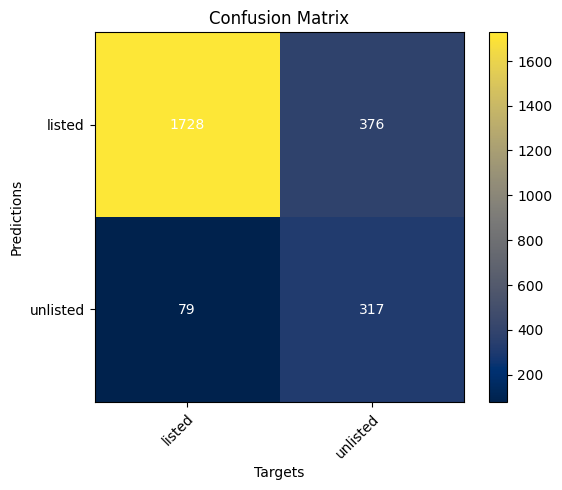

In [19]:
# Evaluation
labels = {"listed":0, "unlisted":1}

print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## Support Vector Machines

In [20]:
from sklearn import svm

model_svm = svm.SVC()
model_svm.fit(X_train, y_train)

SVC()

In [21]:
# Making preditions
y_pred = model_svm.predict(X_val)

              precision    recall  f1-score   support

      listed       0.91      0.89      0.90      1849
    unlisted       0.71      0.75      0.73       651

    accuracy                           0.85      2500
   macro avg       0.81      0.82      0.81      2500
weighted avg       0.86      0.85      0.86      2500



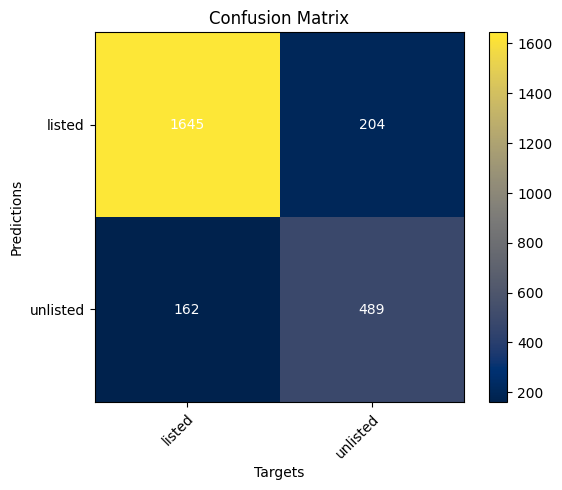

In [22]:
# Evaluation
labels = {"listed":0, "unlisted":1}

print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=100, 
                                      class_weight={0: 0.75, 1: 0.25}, 
                                      random_state=42)

model_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.75, 1: 0.25}, random_state=42)

In [24]:
# Predicting
y_pred = model_forest.predict(X_val)

              precision    recall  f1-score   support

      listed       0.92      0.93      0.92      1787
    unlisted       0.81      0.79      0.80       713

    accuracy                           0.89      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500



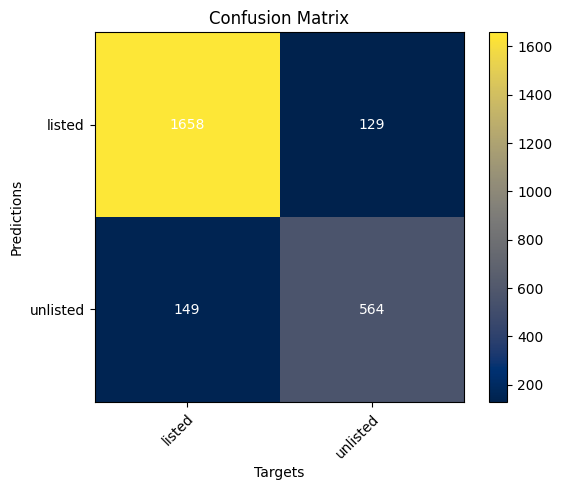

In [25]:
# Evaluation
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## XGBoost model 

In [26]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(scale_pos_weight=0.25, random_state=42)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

              precision    recall  f1-score   support

      listed       0.95      0.86      0.91      1996
    unlisted       0.60      0.83      0.70       504

    accuracy                           0.86      2500
   macro avg       0.78      0.85      0.80      2500
weighted avg       0.88      0.86      0.86      2500



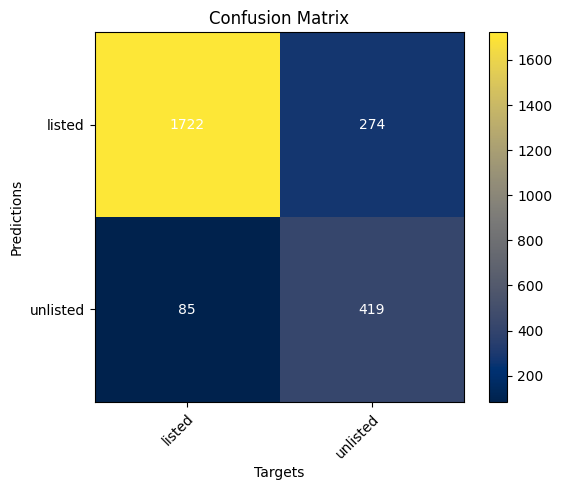

In [27]:
# Predicting
y_pred = model_xgb.predict(X_val)

# Evaluating
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

### Neural Network

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [29]:
# Define the neural network architecture
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out
    

# Set the hyperparameters
input_size = X_val.shape[1]
hidden_size = 100
learning_rate = 0.001
num_epochs = 100

In [30]:
model_nn = BinaryClassifier(input_size, hidden_size)

# Defining the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate)

# Converting the engineered features to torch tensors
features = torch.tensor(X_train, dtype=torch.float32)
targets = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model_nn(features)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out the loss at every 10th epoch
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.6960
Epoch [11/100], Loss: 0.5756
Epoch [21/100], Loss: 0.5336
Epoch [31/100], Loss: 0.4793
Epoch [41/100], Loss: 0.3931
Epoch [51/100], Loss: 0.2858
Epoch [61/100], Loss: 0.1758
Epoch [71/100], Loss: 0.0859
Epoch [81/100], Loss: 0.0353
Epoch [91/100], Loss: 0.0175


In [31]:
# Making predictions with NN
def nn_predict(nn, data, threshold = 0.5):
    new_data = torch.tensor(data, dtype=torch.float32)
    nn.eval() # Set the model in evaluation mode
    with torch.no_grad():
        y_pred = nn(new_data)
    y_pred = y_pred.squeeze().numpy()
    y_pred = np.where(y_pred > threshold, 1, 0)
    return y_pred

In [32]:
y_pred = nn_predict(model_nn, X_val)

              precision    recall  f1-score   support

      listed       0.90      0.88      0.89      1853
    unlisted       0.68      0.73      0.71       647

    accuracy                           0.84      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.85      0.84      0.84      2500



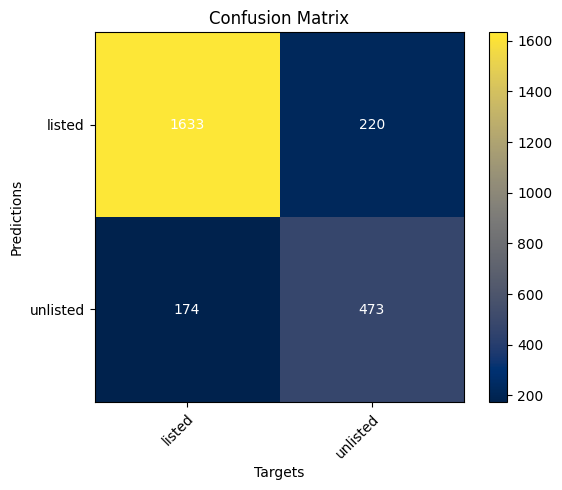

In [33]:
# Evaluating
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

In [34]:
# Save the trained model
#torch.save(model.state_dict(), 'binary_model.pth')